# 波士顿房屋数据

In [1]:
import pandas as pd
from sklearn import datasets as ds
import matplotlib.pyplot as plt
boston = ds.load_boston()
df = pd.DataFrame(data=boston.data)
df.columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
df['MEDV']=boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


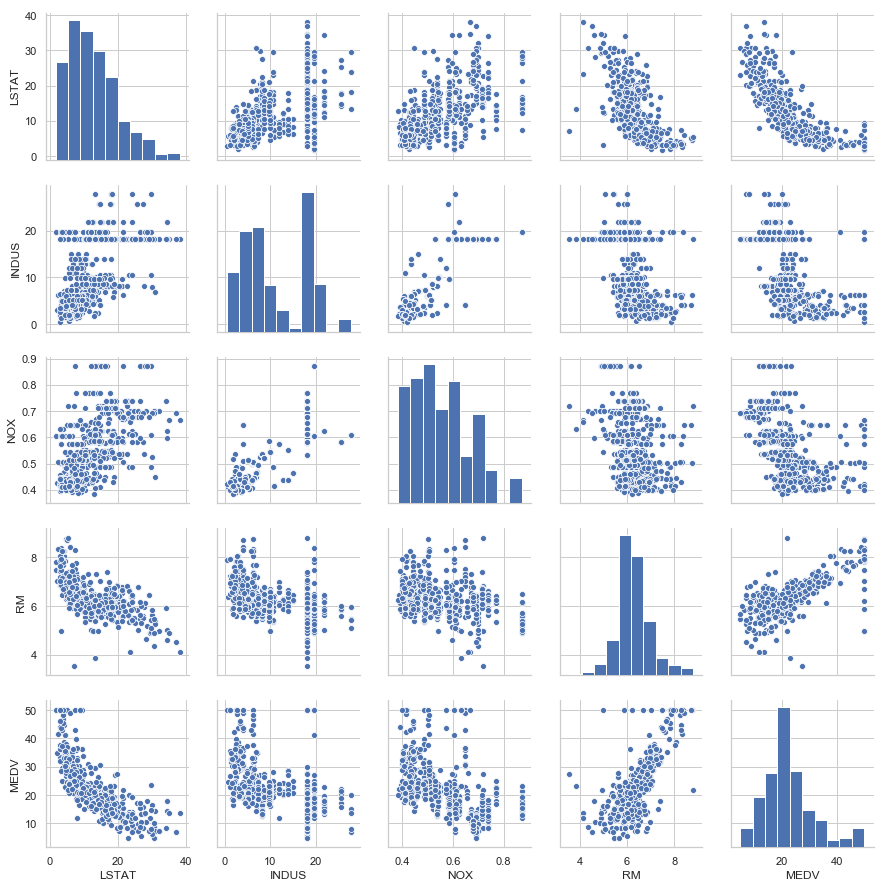

In [2]:
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
cols=['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(df[cols],height=2.5)
plt.show()
#sns.reset_orig()重设matplotlib风格

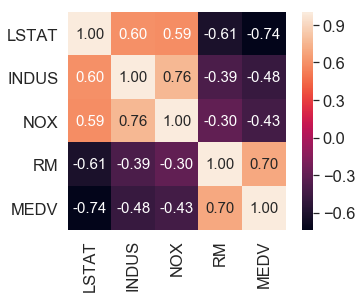

In [3]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm =sns.heatmap(cm,cbar=True,annot=True,square=True,
                fmt='.2f',annot_kws={'size':15},
                yticklabels=cols,xticklabels=cols)
plt.show()

# 最小二乘法-梯度下降

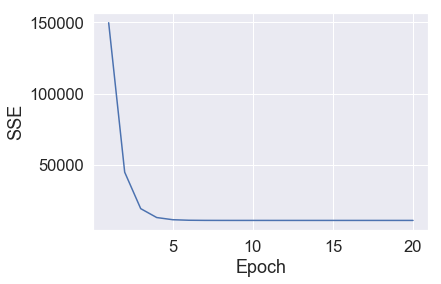

In [4]:
class LinearRegressionGD(object):
    def __init__(self,eta=0.001,n_iter=20):
        '''初始化超参'''
        self.eta=eta#学习速率
        self.n_iter=n_iter#迭代次数
        
    def fit(self,X,y):
        '''训练模型'''
        self.w_ = np.zeros(1+X.shape[1])#初始化W权重
        self.cost_=[]#存储损失函数值
        
        for i in range(self.n_iter):
            '''梯度下降'''
            output = self.net_input(X)
            errors = (y-output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self,X):
        '''计算Y值'''
        return np.dot(X,self.w_[1:]) +self.w_[0]
    
    def predict(self,X):
        return self.net_input(X)
    
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)
lr = LinearRegressionGD()
lr.fit(X_std,y)

#迭代次数与损失函数的关系
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

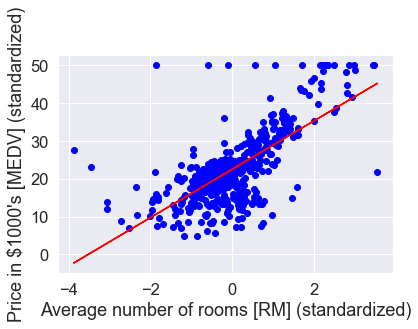

In [5]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='blue')
    plt.plot(X,model.predict(X),color='red')
    return None

lin_regplot(X_std,y,lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

In [6]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % (price_std))
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Price in $1000's: 10.840
Slope: 6.389
Intercept: 22.533


# 最小二乘法-sklearn

Slope: 9.102
Intercept: -34.671


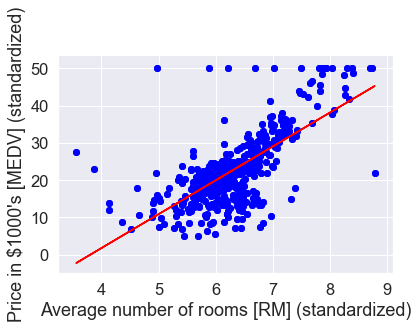

In [7]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)
lin_regplot(X,y,slr)
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

# 使用RANSAC拟合高健壮性回归模型

为了清除异常值对模型的影响，采用随机抽样一致性（RANSAC）算法，使用数据的一个子集来进行回归模型拟合

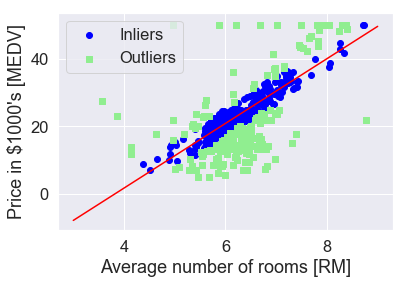

Slope: 9.563
Intercept: -36.479


In [8]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),max_trials=100,#最大迭代次数100 
                         min_samples=50,#随机抽取作为内点的最小样本数为50
                         #residual_threshold=5.0,设定与拟合曲线垂直距离小于5个单位长度样本点才能加入内点，而默认为MAD来设定内点阈值
                         random_state=0)
ransac.fit(X,y)
inlier_mask=ransac.inlier_mask_ #返回布尔类型的ndarray 其中内点为真值
outlier_mask=np.logical_not(inlier_mask)#计算非x元素的真值 x array_like
line_X=np.arange(3,10,1)
line_y_ransac=ransac.predict(line_X[:,np.newaxis])#使得X增加轴，使得1维数组变为2维数组
plt.scatter(X[inlier_mask],y[inlier_mask],
           c='blue',marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],
           c='lightgreen',marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

# 线性回归模型性能的评估

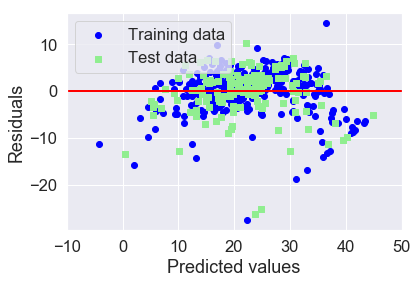

In [9]:
#残差图
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred=slr.predict(X_train)
y_test_pred=slr.predict(X_test)
plt.scatter(y_train_pred,y_train_pred-y_train,
           c='blue',marker='o',label='Training data')
plt.scatter(y_test_pred,y_test_pred-y_test,
            c='lightgreen',marker='s',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='red')
plt.xlim([-10,50])
plt.show()

In [10]:
#均方误差MSE,越大越差
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train,y_train_pred),
                                      mean_squared_error(y_test,y_test_pred)))

MSE train: 19.958, test: 27.196


In [11]:
#决定系数R^2
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
     (r2_score(y_train,y_train_pred),
     r2_score(y_test,y_test_pred)))

R^2 train: 0.765, test: 0.673


# 回归中的正则化方法

In [12]:
#岭回归 l2
from sklearn.linear_model import Ridge
ridge =Ridge(alpha=1.0)
#套索回归 l1
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
#弹性网络 l1+l2
from sklearn.linear_model import ElasticNet
ela = ElasticNet(alpha=1.0,l1_ratio=0.5)

# 多项式回归

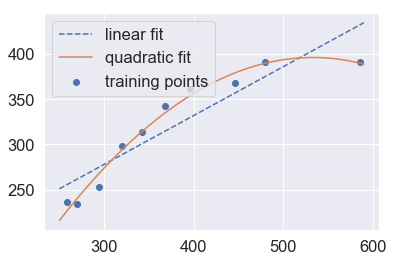

In [13]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0,270.0,294.0,320.0,342.0,368.0,396.0,446.0,480.0,586.0])[:,np.newaxis]
y = np.array([236.4,234.4,252.8,298.6,314.2,342.2,360.8,368.0,391.2,390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
lr.fit(X,y)
X_fit=np.arange(250,600,10)[:,np.newaxis]
y_lin_fit=lr.predict(X_fit)
pr.fit(X_quad,y)
y_quad_fit=pr.predict(quadratic.fit_transform(X_fit))
plt.scatter(X,y,label='training points')
plt.plot(X_fit,y_lin_fit,label='linear fit',linestyle='--')
plt.plot(X_fit,y_quad_fit,label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [14]:
y_lin_pred =lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
    mean_squared_error(y,y_lin_pred),
    mean_squared_error(y,y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
    r2_score(y,y_lin_pred),
    r2_score(y,y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


# 多项式回归-非线性建模

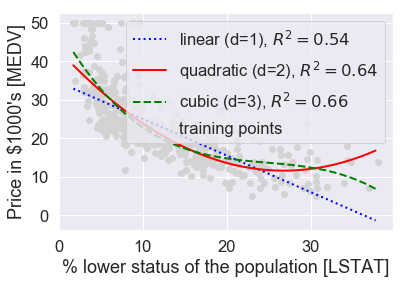

In [15]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear_fit
X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]
regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

#quadratic fit
regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y,regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

#plot results
plt.scatter(X,y,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label='linear (d=1), $R^2=%.2f$' % linear_r2,color='blue',lw=2,linestyle=':')
plt.plot(X_fit,y_quad_fit,label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,color='red',lw=2,linestyle='-')
plt.plot(X_fit,y_cubic_fit,label='cubic (d=3), $R^2=%.2f$' % cubic_r2,color='green',lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

将解释变量映射到对数空间以及取目标变量的平方根后，可以捕获到两者之间的线性关系

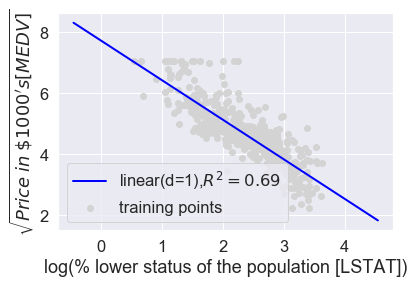

In [16]:
#transfor features
X_log =np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1,
                  X_log.max()+1,1)[:,np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 =r2_score(y_sqrt,regr.predict(X_log))

#plot results
plt.scatter(X_log,y_sqrt,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label='linear(d=1),$R^2=%.2f$' % linear_r2,color='blue',lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

# 曲线化-随机森林

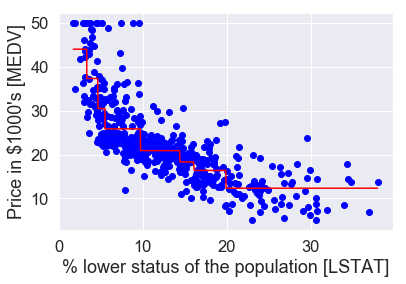

In [39]:
#决策树回归
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

MSE train: 1.641, test: 11.056
R^2 train: 0.979, test: 0.878


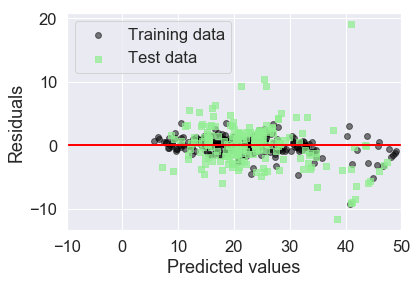

In [49]:
#随机森林
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)))
plt.scatter(y_train_pred,y_train_pred-y_train,c='black',marker='o',s=35,alpha=0.5,label='Training data')
plt.scatter(y_test_pred,y_test_pred-y_test,c='lightgreen',marker='s',s=35,alpha=0.7,label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='red')
plt.xlim([-10,50])
plt.show()